# Lab 3 Report: 
## MNIST Classification with FCN

In [182]:
# Import necessary packages

%matplotlib inline
import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torchvision
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [183]:
from IPython.display import Image # For displaying images in colab jupyter cell

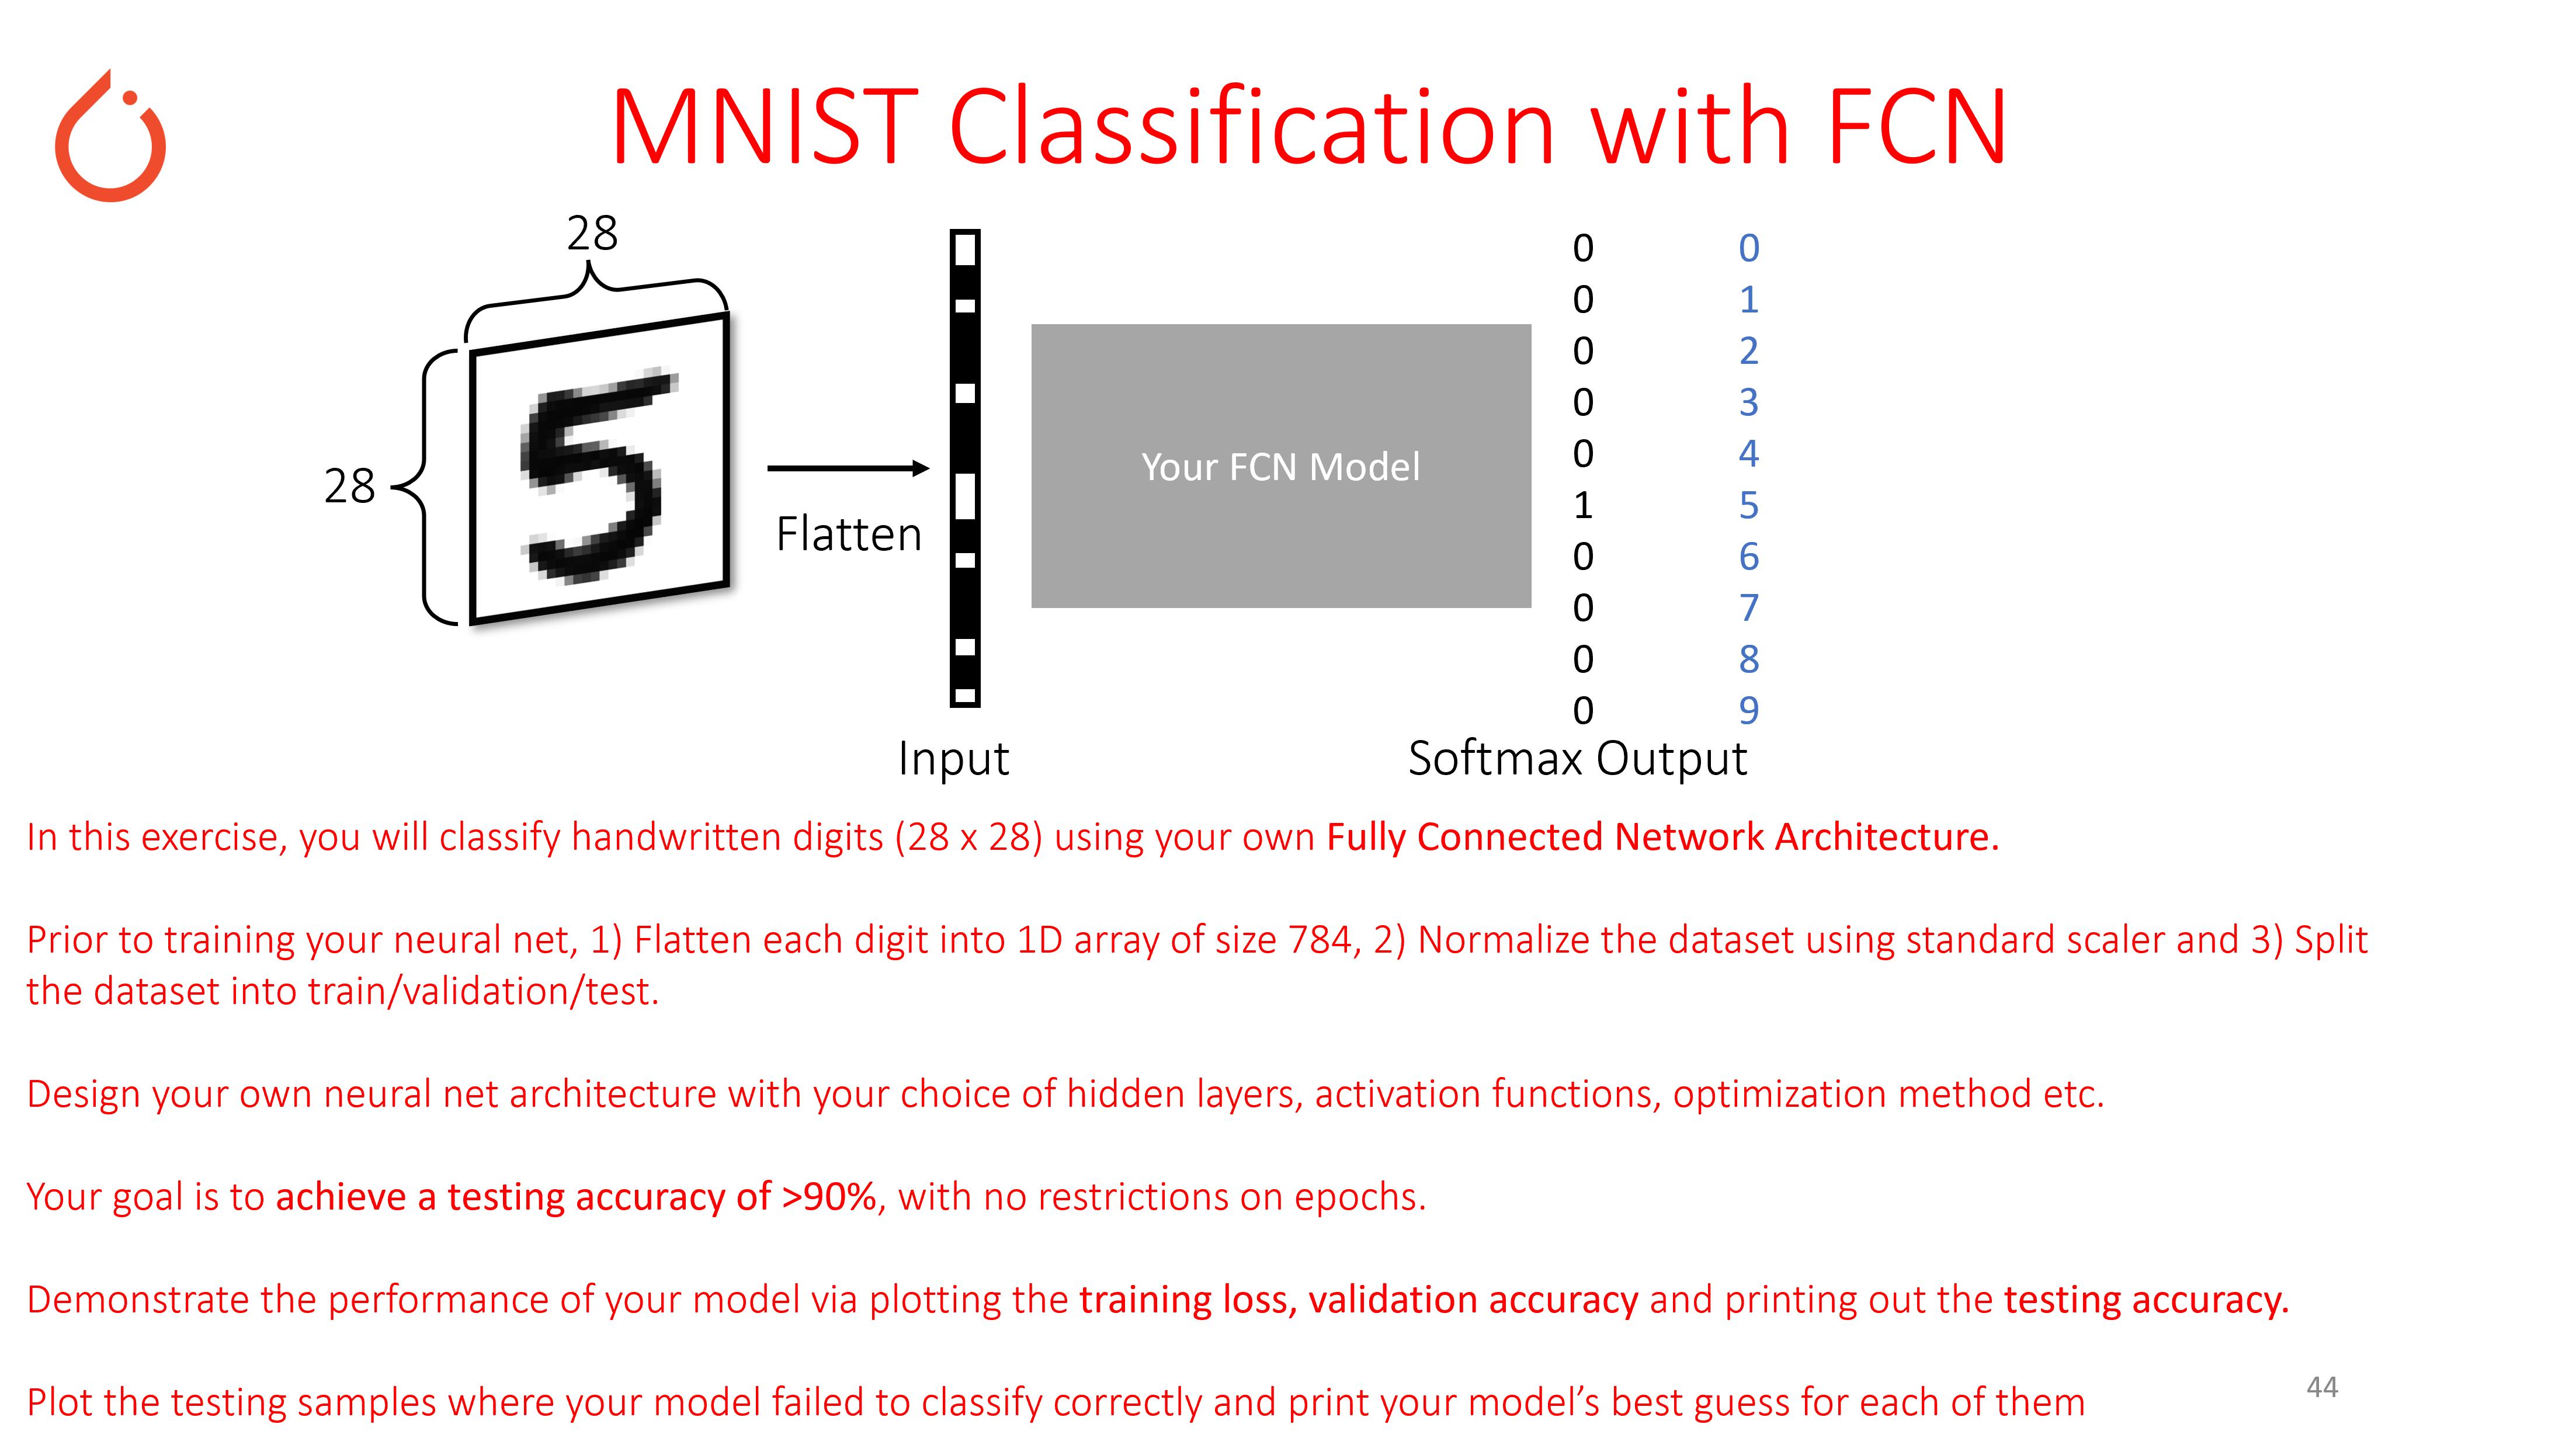

In [184]:
Image('/Users/xuzhaozhong/Downloads/Lab3_Template/lab3_exercise.PNG', width = 1000)

### Prepare Data

In [185]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


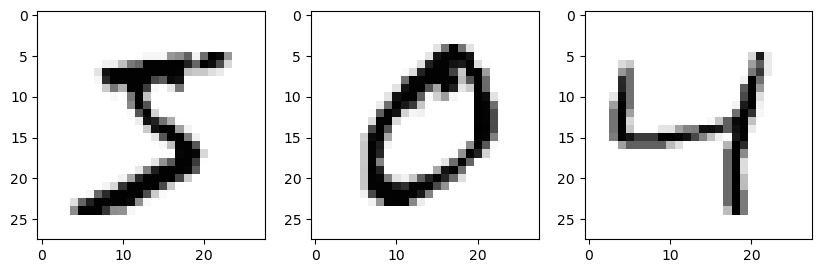

In [186]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [187]:
# Reshape features via flattening the images
# The reshaped training/testing features should have shape (1000, 784) and (100, 784) respectively
# np.reshape() function could be useful here

mnist_train_features = mnist_train_features.reshape(-1,28*28)
mnist_test_features = mnist_test_features.reshape(-1,28*28)

print(mnist_train_features.shape, mnist_test_features.shape)

(1000, 784) (100, 784)


In [188]:
# Scale the dataset according to standard scaling
scaler = StandardScaler()
mnist_train_features = scaler.fit_transform(mnist_train_features)
mnist_test_features = scaler.fit_transform(mnist_test_features)

In [189]:
# Split dataset into Train (900 samples), Validation (100 samples), Testing (100 samples)

mnist_validation_features = mnist_train_features[:int(len(mnist_test_features))]
mnist_validation_targets = mnist_train_targets[:int(len(mnist_test_features))]

mnist_train_features = mnist_train_features[int(len(mnist_test_features)):]
mnist_train_targets = mnist_train_targets[int(len(mnist_test_features)):]
print(mnist_train_features.shape, mnist_validation_features.shape,mnist_test_features.shape)

(900, 784) (100, 784) (100, 784)


### Define Model

In [190]:
class mnistClassificationFCN(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2 , output_dim): # Feel free to add hidden_dim as parameters here
        
        super(mnistClassificationFCN, self).__init__()
        
        self.layer1=torch.nn.Linear(input_dim,hidden_dim1)
        self.layer2=torch.nn.Linear(hidden_dim1,hidden_dim2)
        self.layer3=torch.nn.Linear(hidden_dim2,output_dim)
        self.dropout=torch.nn.Dropout(p=0.5)
    def forward(self, x):
        
        out = torch.nn.functional.relu(self.layer1(x)) 
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.layer2(out))
        out = self.dropout(out)
        out = self.layer3(out)
        out = torch.softmax(out, dim=1)
        return out

### Define Hyperparameters

In [191]:
# Initialize our neural network model with input and output dimensions
model = mnistClassificationFCN(input_dim = 784, output_dim = 10, hidden_dim1 = 1024, hidden_dim2 = 1024)

# Define the learning rate and epoch 
learning_rate = 0.0022
epochs = 100
batchsize = 200 #(If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0.01)
model

mnistClassificationFCN(
  (layer1): Linear(in_features=784, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Identify Tracked Values

In [192]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch
iterations_per_epoch = len(mnist_train_features) // batchsize
train_loss_list = np.zeros(int(epochs*iterations_per_epoch,))
validation_accuracy_list = np.zeros((epochs,))

### Train Model

In [193]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(mnist_train_features).float()
train_targets = torch.from_numpy(mnist_train_targets).long() # Convert to 64-bit integer

validation_inputs = torch.from_numpy(mnist_validation_features).float()
validation_targets = torch.from_numpy(mnist_validation_targets).long()

testing_inputs = torch.from_numpy(mnist_test_features).float()
testing_targets = torch.from_numpy(mnist_test_targets).long()

# Training Loop ---------------------------------------------------------------------------------------

iteration = 0
for epoch in tqdm.trange(epochs):
    for i in range(iterations_per_epoch):
        start_idx = i * batchsize
        end_idx = (i + 1) * batchsize
        
        inputs = train_inputs[start_idx:end_idx]
        targets = train_targets[start_idx:end_idx]
        
        optimizer.zero_grad()
        
        train_outputs = model(inputs)
        
        loss = loss_func(train_outputs, targets)
        
        train_loss_list[iteration] = loss.item()
        
        loss.backward()
        outputs = model(validation_inputs)
        _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
        correct = (predicted == validation_targets).sum().item()
        total = validation_targets.size(0)
        accuracy = correct / total
        validation_accuracy_list[epoch] = accuracy 
        
        optimizer.step()
        
        iteration += 1
    
    # Compute Validation Accuracy ----------------------------------------------------------------------

with torch.no_grad():#Indicates that we don't need to compute gradients in the following code block (used for evaluation)
    outputs = model(validation_inputs)
    _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
    correct = (predicted == validation_targets).sum().item()
    total = validation_targets.size(0)
    accuracy = correct / total
    print('Accuracy: {:.2f}'.format(accuracy))
    

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]

Accuracy: 0.92


### Visualize and Evaluate Model

In [194]:
# Import seaborn for prettier plots

import seaborn as sns

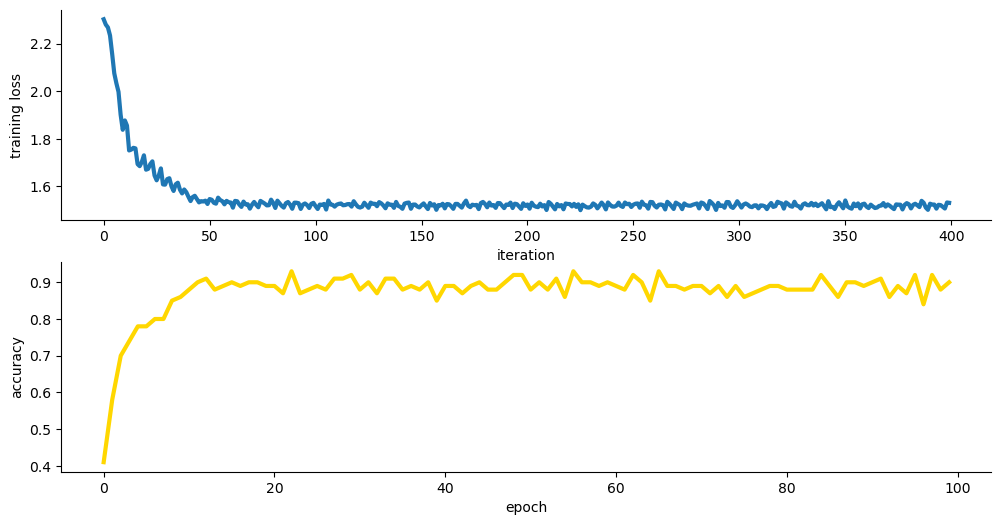

In [195]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iteration")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("accuracy")
plt.xlabel("epoch")
sns.despine()

Accuracy: 0.91
tensor([[ 8],
        [18],
        [32],
        [44],
        [61],
        [65],
        [66],
        [80],
        [87]])
Predicted: 0
Predicted: 2
Predicted: 5
Predicted: 5
Predicted: 2
Predicted: 5
Predicted: 2
Predicted: 9
Predicted: 5


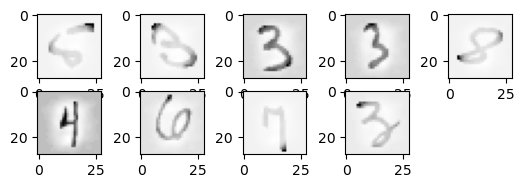

In [205]:
with torch.no_grad():#Indicates that we don't need to compute gradients in the following code block (used for evaluation)
    outputs = model(testing_inputs)
    _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
    correct = (predicted == testing_targets).sum().item()
    total = testing_targets.size(0)
    accuracy = correct / total
    print('Accuracy: {:.2f}'.format(accuracy))
    # Find incorrectly classified samples
    incorrect_idx = (predicted != testing_targets).nonzero()
    print(incorrect_idx)
    plt.subplot(5,5,1)
    plt.imshow(mnist_test_features[97].reshape(28,28), cmap = 'Greys')
    for i, idx in enumerate(incorrect_idx):
        plt.subplot(5,5,i+1)
        plt.imshow(mnist_test_features[idx].reshape(28,28), cmap = 'Greys')
        print('Predicted: {}'.format(predicted[idx].item()))